In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

# model_dir = './models/'
model_file = 'vit_brain_mri.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o /content/drive/MyDrive/dataset_19.zip

! pwd

Archive:  /content/drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflat

# Load the Data

In [4]:
# Data Directories
dir = "dataset_19/"
validation_dir = "Testing"

# Data Distribution

In [5]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

notumor       120
glioma        120
pituitary     120
meningioma    120
dtype: int64

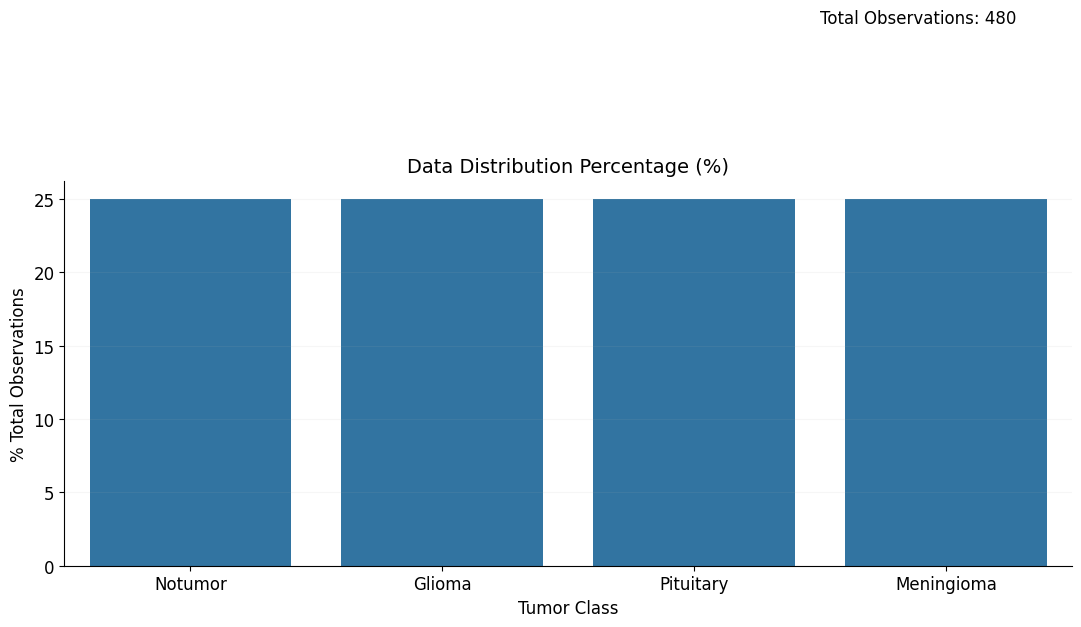

In [6]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess the Data

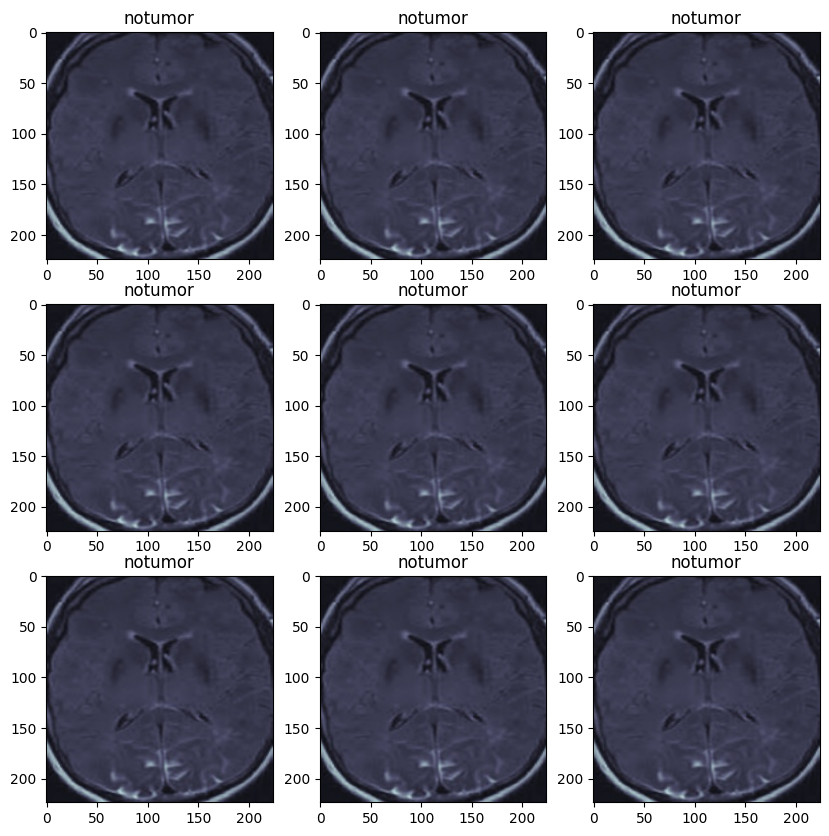

In [7]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

# Splitting the Data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


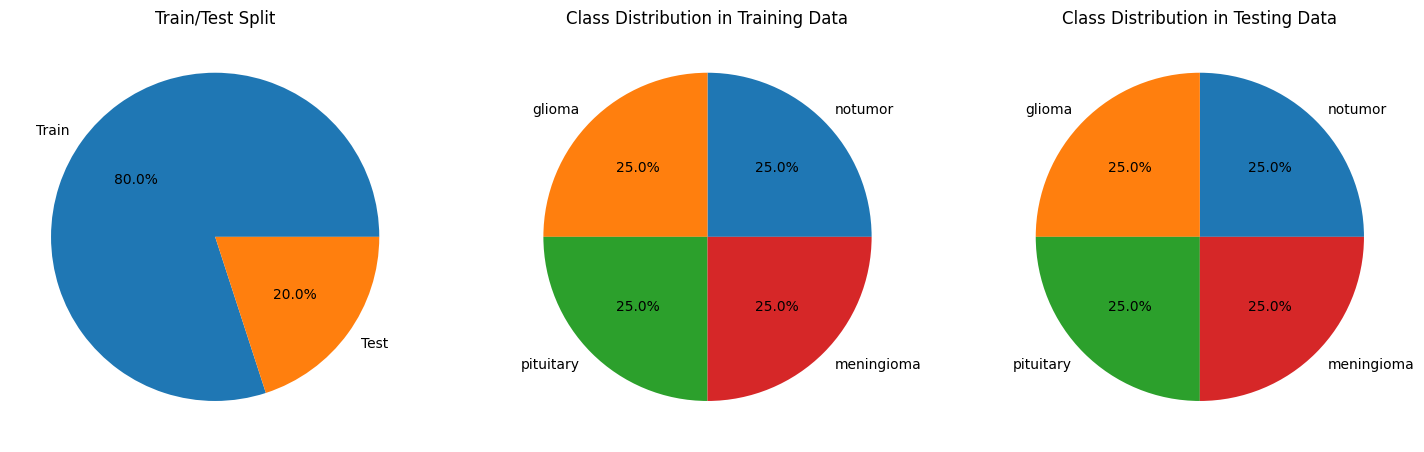

In [8]:
classes = os.listdir(dir)
batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation',
    shuffle = False)


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()

# To Check Data Loading and Augmentation


In [9]:
print(train_generator.class_indices)
print(test_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Installing TensorFlow Addon and vit-keras Package

In [10]:
! pip install tensorflow-addons vit-keras
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.6 MB/s eta 0:00:00


# Training a Vision Transformer (ViT) model



In [11]:
from transformers import ViTForImageClassification, ViTConfig, ViTModel
from tensorflow.keras.layers import Input, Dropout, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit, layers
from sklearn.utils.class_weight import compute_class_weight
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import optuna
from tensorflow.keras.regularizers import l2

def create_vit_model(input_shape, num_classes, learning_rate, dropout_rate=0.3):
    vit_model = vit.vit_b16(
        image_size=input_shape[0],  # Assuming input_shape is (height, width, channels)
        activation='softmax',
        pretrained=True,
        include_top=False,  # Ensure this is set to False if custom layers are added
        pretrained_top=False,
        classes=num_classes
    )

    inputs = Input(shape=input_shape)
    x = vit_model(inputs)

    # Check the shape of 'x' to decide on applying pooling
    if len(x.shape) == 4:  # If the output includes spatial dimensions
        x = GlobalAveragePooling2D()(x)  # Only apply if spatial dimensions are present

    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate),
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

# Parameters
input_shape = (224, 224, 3)
num_classes = len(classes)  # Define the number of your classes
learning_rate = 0.0001  # Fixed learning rate
dropout_rate = 0.3  # Fixed dropout rate

# Create and train the model
model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

model.summary()

# Setup callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-6)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,  # You can adjust this based on your training need
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    class_weight=class_weights
)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 86194436 (328.81 MB)
Trainable params: 86194436 (328.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
38/38 

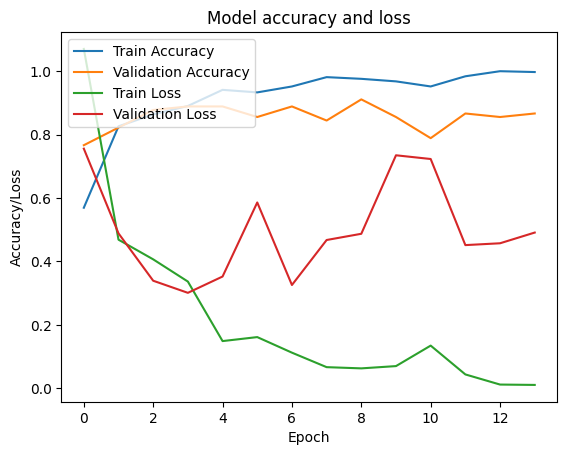

In [12]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy and loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.legend(['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

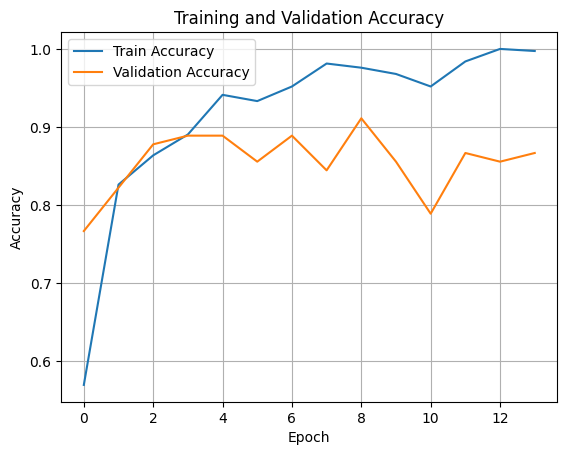

In [13]:
# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Training and Validation Accuracy')  # Title of the plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Accuracy')  # Y-axis label
plt.legend()  # Add a legend to specify which line is which
plt.grid(True)  # Add grid for better readability
plt.show()  # Display the plot

**Model Visualisation (Evaluation)**

10/10 [==============================] - 4s 142ms/step


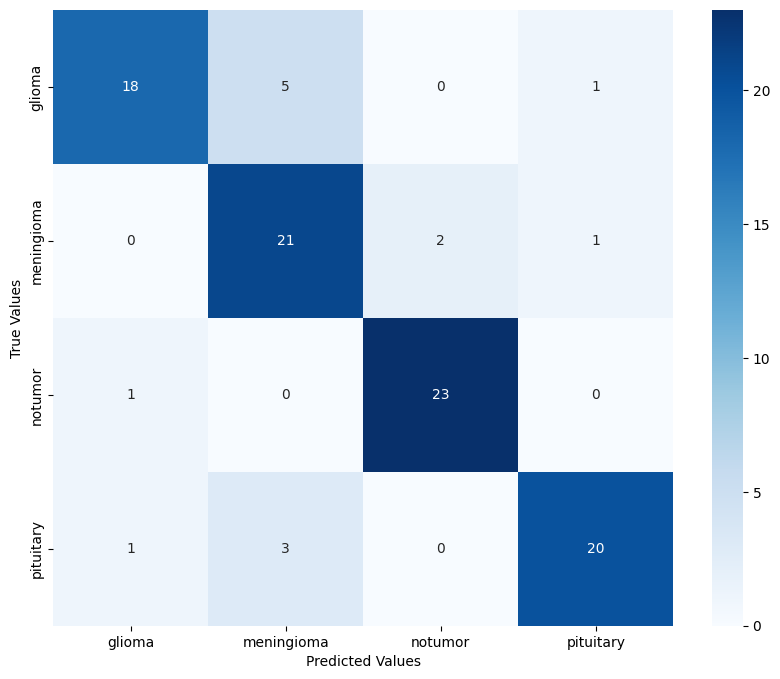

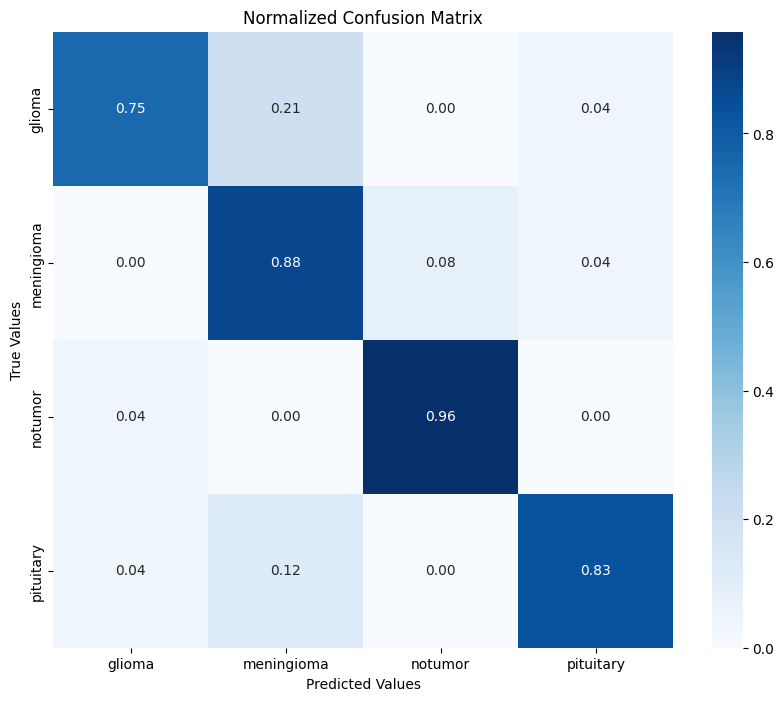

DSC: 0.8547438439914709, Sensitivity: 0.8541666666666667, Specificity: 0.951388888888889, Accuracy: 0.8541666666666666


In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

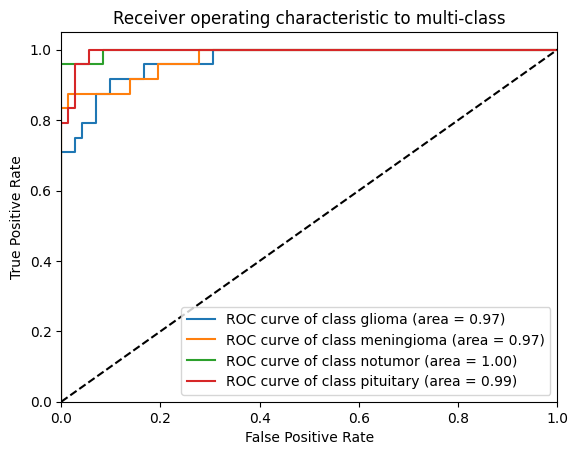

              precision    recall  f1-score   support

      glioma       0.90      0.75      0.82        24
  meningioma       0.72      0.88      0.79        24
     notumor       0.92      0.96      0.94        24
   pituitary       0.91      0.83      0.87        24

   micro avg       0.85      0.85      0.85        96
   macro avg       0.86      0.85      0.85        96
weighted avg       0.86      0.85      0.85        96
 samples avg       0.85      0.85      0.85        96



In [15]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20
)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Define the ViT Model
    model = create_vit_model(input_shape, num_classes, learning_rate, dropout_rate)

    # # Add a GlobalAveragePooling2D layer and Dense layer with softmax activation
    # model = keras.Sequential([
    #     model,
    #     keras.layers.GlobalAveragePooling2D(),  # Pool across spatial dimensions
    #     keras.layers.Dense(num_classes, activation='softmax')  # Final classification layer
    # ])

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    # checkpoint = ModelCheckpoint(f'model_fold_{fold + 1}.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=35,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')

Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/35
38/38 [==============================] - 56s 538ms/step - loss: 1.0397 - accuracy: 0.5856 - val_loss: 0.5436 - val_accuracy: 0.7778 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 18s 470ms/step - loss: 0.5139 - accuracy: 0.8262 - val_loss: 0.4601 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 18s 463ms/step - loss: 0.3043 - accuracy: 0.8824 - val_loss: 0.3307 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 18s 459ms/step - loss: 0.1820 - accuracy: 0.9358 - val_loss: 0.5762 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 18s 459ms/step - loss: 0.2655 - accuracy: 0.9091 - val_loss: 0.3873 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 18s 461ms/step - loss: 0.1479 - accuracy: 0.9439 - val_loss: 0.2641 - val_accuracy: 0.8889 - lr: 1.0000e-04
Epoch 7/35
38/38 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/35
38/38 [==============================] - 56s 532ms/step - loss: 1.2157 - accuracy: 0.4947 - val_loss: 0.6741 - val_accuracy: 0.7222 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 18s 470ms/step - loss: 0.4847 - accuracy: 0.7834 - val_loss: 0.5457 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 18s 467ms/step - loss: 0.2731 - accuracy: 0.9064 - val_loss: 0.3699 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 18s 460ms/step - loss: 0.2356 - accuracy: 0.9251 - val_loss: 0.4739 - val_accuracy: 0.8556 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 18s 459ms/step - loss: 0.1244 - accuracy: 0.9545 - val_loss: 0.3404 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 18s 461ms/step - loss: 0.1248 - accuracy: 0.9545 - val_loss: 0.4372 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 7/35
38/38 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/35
38/38 [==============================] - 56s 532ms/step - loss: 1.2052 - accuracy: 0.5134 - val_loss: 0.4992 - val_accuracy: 0.8111 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 18s 472ms/step - loss: 0.6381 - accuracy: 0.7513 - val_loss: 0.4583 - val_accuracy: 0.8222 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 18s 469ms/step - loss: 0.3828 - accuracy: 0.8529 - val_loss: 0.3958 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 18s 462ms/step - loss: 0.2593 - accuracy: 0.9011 - val_loss: 0.3077 - val_accuracy: 0.8778 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 18s 459ms/step - loss: 0.2037 - accuracy: 0.9412 - val_loss: 0.3679 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 18s 460ms/step - loss: 0.0784 - accuracy: 0.9733 - val_loss: 0.2177 - val_accuracy: 0.9111 - lr: 1.0000e-04
Epoch 7/35
38/38 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/35
38/38 [==============================] - 57s 532ms/step - loss: 1.1913 - accuracy: 0.5027 - val_loss: 0.6895 - val_accuracy: 0.7444 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 18s 470ms/step - loss: 0.4955 - accuracy: 0.8075 - val_loss: 0.3512 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 18s 469ms/step - loss: 0.3799 - accuracy: 0.8583 - val_loss: 0.2697 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 18s 460ms/step - loss: 0.1685 - accuracy: 0.9385 - val_loss: 0.3947 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 17s 458ms/step - loss: 0.1019 - accuracy: 0.9652 - val_loss: 0.2281 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 18s 460ms/step - loss: 0.0965 - accuracy: 0.9626 - val_loss: 0.2678 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 7/35
38/38 [======================

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


Epoch 1/35
38/38 [==============================] - 54s 536ms/step - loss: 1.0499 - accuracy: 0.5711 - val_loss: 0.3826 - val_accuracy: 0.8444 - lr: 1.0000e-04
Epoch 2/35
38/38 [==============================] - 18s 471ms/step - loss: 0.5775 - accuracy: 0.7647 - val_loss: 0.3120 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 3/35
38/38 [==============================] - 18s 466ms/step - loss: 0.2963 - accuracy: 0.8824 - val_loss: 0.4261 - val_accuracy: 0.8667 - lr: 1.0000e-04
Epoch 4/35
38/38 [==============================] - 18s 460ms/step - loss: 0.2487 - accuracy: 0.9118 - val_loss: 0.2055 - val_accuracy: 0.9444 - lr: 1.0000e-04
Epoch 5/35
38/38 [==============================] - 17s 458ms/step - loss: 0.1549 - accuracy: 0.9492 - val_loss: 0.1821 - val_accuracy: 0.9222 - lr: 1.0000e-04
Epoch 6/35
38/38 [==============================] - 18s 460ms/step - loss: 0.1770 - accuracy: 0.9465 - val_loss: 0.3297 - val_accuracy: 0.9000 - lr: 1.0000e-04
Epoch 7/35
38/38 [======================

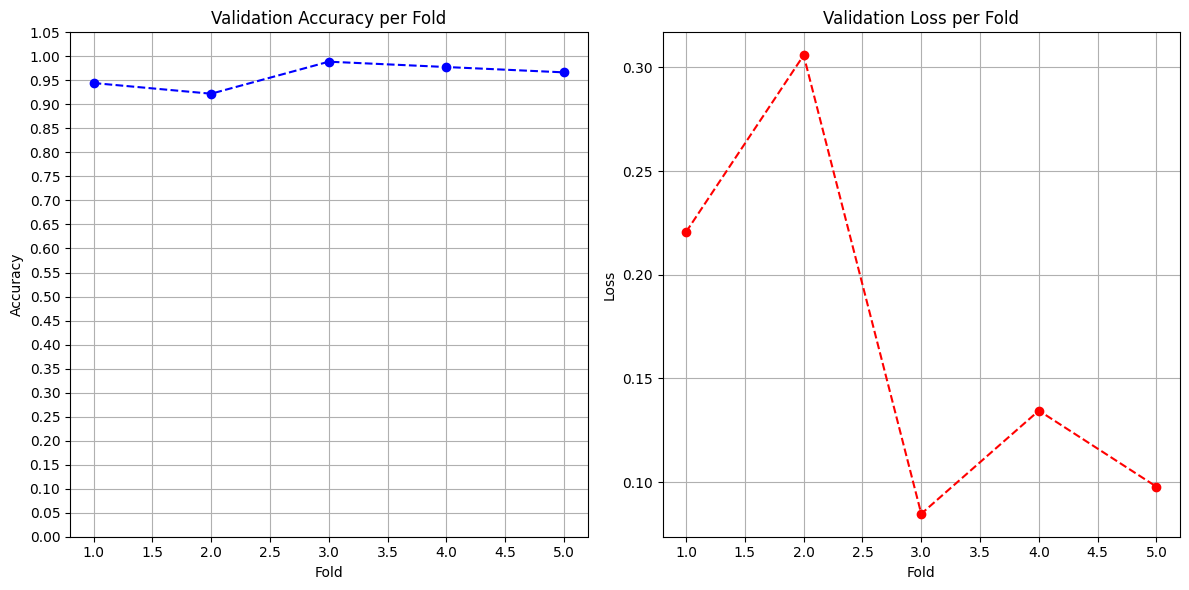

In [19]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()